In [1]:
import pymongo as pm
#conn = pm.MongoClient(port=27016)
conn = pm.MongoClient(port=27017)
conn_2 = pm.MongoClient(port=29101)

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

In [3]:
from scipy import misc

In [26]:
import os
import time

In [37]:
conn['normalnet-test']['normalnet.files'].distinct('exp_id')

[u'trainval_tfr',
 u'trainval_tfr_nocrop',
 u'trainval_tfr_largecapa',
 u'validation1',
 u'trainval_vgg',
 u'trainval_vgg_invdot',
 u'trainval_vgg_invdot_slow']

In [3]:
conn_2['combinet-test']['combinet.files'].distinct('exp_id')

[u'combinet_test']

In [70]:
curr_expid = u'trainval1'

In [23]:
def show_train_learnrate(curr_expid, conn = conn):
    train_vec = np.concatenate([[(_r['loss'], _r['learning_rate']) for _r in r['train_results']] 
                            for r in conn['normalnet-test']['normalnet.files'].find(
                                       {'exp_id': curr_expid, 'train_results': {'$exists': True}})])

    _N = 50
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_vec[_N:, 0])
    plt.title('Training loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_vec[_N:, 1])
    plt.title('Learning Rate')



    #plt.gca().set_xscale('log')


In [33]:
def show_val(curr_expid, conn = conn, key = 'loss'):
    test_vec = [r['validation_results']['topn'][key] for r in conn['normalnet-test']['normalnet.files'].find({'exp_id': curr_expid,
                                                                                        'validation_results': {'$exists': True}})]
    _N = 1
    plt.plot(test_vec[_N:])
    #plt.gca().set_xscale('log')
    plt.title('Validation Loss')    

In [117]:
exp_id_now = 'val_test'
#exp_id_now = 'validation1'

r = conn['normalnet-test']['normalnet.files'].find({'exp_id': exp_id_now, 'validation_results': {'$exists': True}})
r.count()

15

In [119]:
idval = r[0]['_id']

In [120]:
coll = conn['normalnet-test']['normalnet.files']
fn = coll.find({'item_for': idval})[0]['filename']

In [121]:
fn

u'58b8ab86bd64ff6ede96dbe0_fileitems'

In [124]:
import gridfs
import cPickle

fs = gridfs.GridFS(coll.database, 'normalnet')
fh = fs.get_last_version(fn)
saved_data = cPickle.loads(fh.read())
fh.close()

In [130]:
saved_data['validation_results']['feats']['outputs_fea'][0].shape

(5, 224, 224, 3)

# Network from hdf5

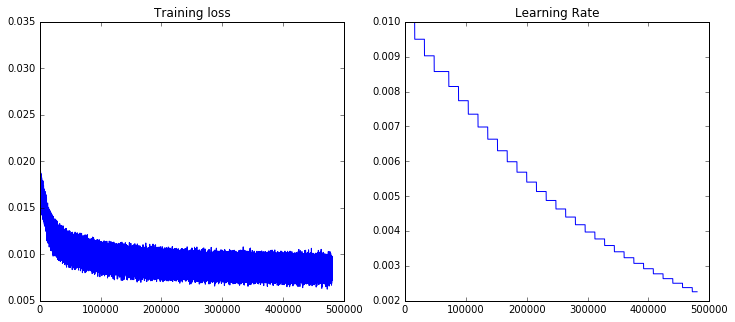

In [74]:
show_train_learnrate(curr_expid)

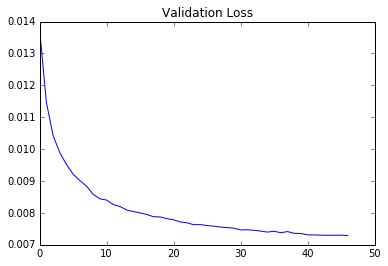

In [76]:
show_val(curr_expid)

In [80]:
tf_expid = u'trainval1_tfr_bf'

# Network from tfrecords

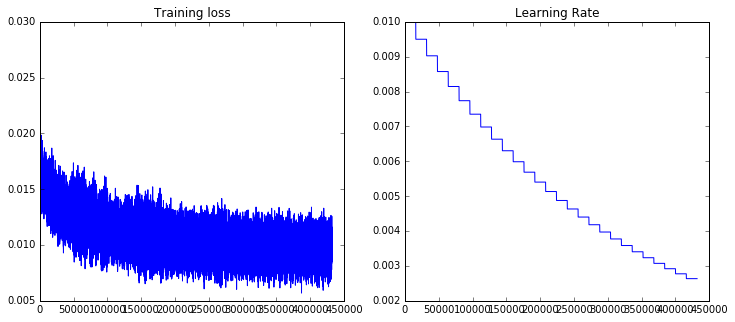

In [81]:
show_train_learnrate(tf_expid)

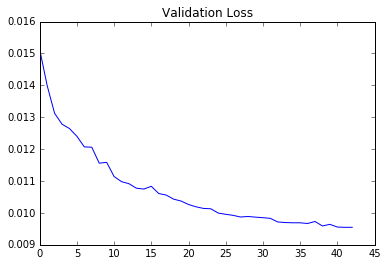

In [82]:
show_val(tf_expid)

# To get some prediction

In [144]:
import cPickle
normals_part = cPickle.load(open('normals_part.pkl', 'r'))

In [145]:
images_part = cPickle.load(open('images_part.pkl', 'r'))

In [189]:
def show_result_with_labels(indx_now, features):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    result = features[indx_now]
    #result = features_2[indx_now]
    #result = features_3[indx_now]
    ax1.imshow(result)
    
    mid_indx = (256 - 224)/2
    label_now = normals_part[indx_now+1, mid_indx:(mid_indx+224), mid_indx:(mid_indx+224), :]
    ax2.imshow(label_now)
    
    image_now = images_part[indx_now+1, mid_indx:(mid_indx+224), mid_indx:(mid_indx+224), :]
    ax3.imshow(image_now)
    

In [180]:
saved_data = cPickle.load(open('save_features_hdf5.pkl', 'r'))
features = saved_data['validation_results']['valid1']['features']

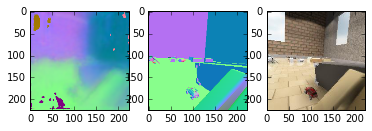

In [197]:
show_result_with_labels(9, features)

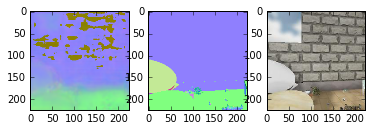

In [207]:
show_result_with_labels(16, features)

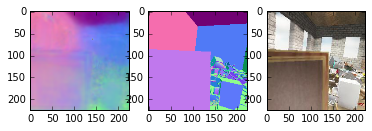

In [215]:
show_result_with_labels(21, features)

# Progress of fcnvgg16

- The network from paper "Physically-Based Rendering for Indoor Scene Understanding Using Convolutional Neural Networks", 
- trained using L2-loss, batchsize 32.

In [54]:
conn['normalnet-test']['normalnet.files'].distinct('exp_id')

[u'trainval_tfr',
 u'trainval_tfr_nocrop',
 u'trainval_tfr_largecapa',
 u'validation1',
 u'trainval_vgg',
 u'trainval_vgg_invdot',
 u'trainval_vgg_invdot_slow',
 u'val_test']

In [ ]:
show_train_learnrate(u'trainval_vgg')
show_val(u'trainval_vgg')

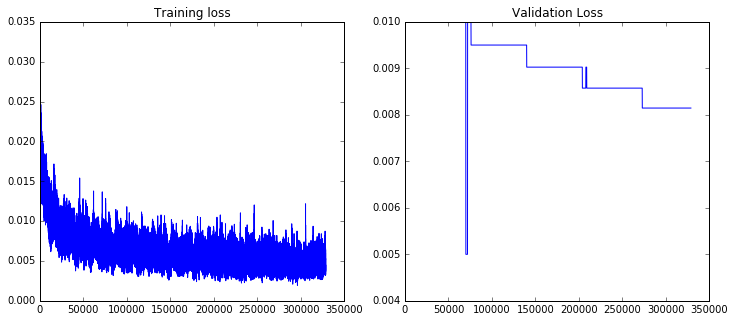

In [172]:
show_train_learnrate(u'trainval_vgg')
show_val(u'trainval_vgg')

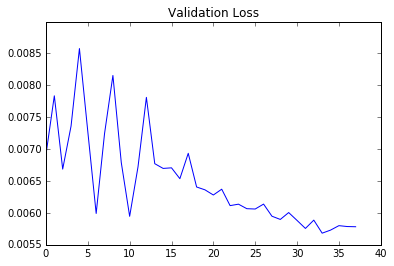

In [194]:
show_val(u'trainval_vgg')

In [135]:
exp_id_now = 'trainval_vgg'
#exp_id_now = 'validation1'

r = conn['normalnet-test']['normalnet.files'].find({'exp_id': exp_id_now, 'validation_results': {'$exists': True}})
r.count()

25

In [150]:
idval = r[21]['_id']

In [151]:
coll = conn['normalnet-test']['normalnet.files']
fn = coll.find({'item_for': idval})[0]['filename']

In [152]:
fn

u'58b8f734bd64ff3dd7bd30de_fileitems'

In [153]:
import gridfs
import cPickle

fs = gridfs.GridFS(coll.database, 'normalnet')
fh = fs.get_last_version(fn)
saved_data = cPickle.loads(fh.read())
fh.close()

In [154]:
saved_data['validation_results']['feats']['outputs_fea'][0].shape

(5, 224, 224, 3)

In [177]:
vis_big_dict = {}

In [185]:
def show_result_from_mongodb(exp_id_now, indx_rec, which_save = 0, which_exam = 0, 
                             conn = conn, cache_flag = False, big_dict = vis_big_dict, inv_norm = False):
    r = conn['normalnet-test']['normalnet.files'].find({'exp_id': exp_id_now, 'validation_results': {'$exists': True}})
    idval = r[indx_rec]['_id']
    coll = conn['normalnet-test']['normalnet.files']
    fn = coll.find({'item_for': idval})[0]['filename']

    if fn in big_dict:
        saved_data = big_dict[fn]
    else:
        fs = gridfs.GridFS(coll.database, 'normalnet')
        fh = fs.get_last_version(fn)
        saved_data = cPickle.loads(fh.read())
        fh.close()

        if cache_flag:
            big_dict[fn] = saved_data
    
    output_now = saved_data['validation_results']['feats']['outputs_fea'][which_save][which_exam]
    normal_now = saved_data['validation_results']['feats']['normals_fea'][which_save][which_exam]
    image_now = saved_data['validation_results']['feats']['images_fea'][which_save][which_exam]
    
    if inv_norm:
        orig_norm = np.linalg.norm(normal_now, axis = 2)
        new_norm = np.linalg.norm(output_now, axis = 2)
        for im_indx1 in xrange(output_now.shape[0]):
            for im_indx2 in xrange(output_now.shape[1]):
                output_now[im_indx1][im_indx2] = output_now[im_indx1][im_indx2]/new_norm[im_indx1][im_indx2]*orig_norm[im_indx1][im_indx2]                

    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(output_now)
    ax1.axis('off')
    ax2.imshow(normal_now)
    ax2.axis('off')
    ax3.imshow(image_now)
    plt.gcf().set_size_inches(10.5, 4.5)
    ax3.axis('off')

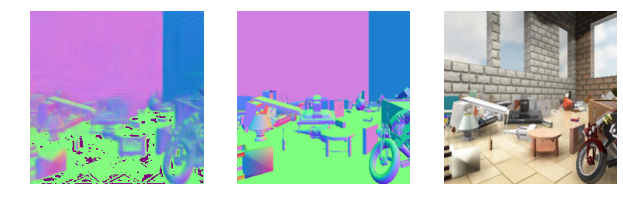

In [170]:
show_result_from_mongodb(exp_id_now, 21, 1, 3)

## Results from om7
- Networks Trained using invdot loss, smaller learning rate

In [25]:
conn_mit = pm.MongoClient(port=27016)

In [173]:
conn_mit['normalnet-test']['normalnet.files'].distinct('exp_id')

[u'trainval1_tfr',
 u'trainval1',
 u'trainval1_tfr_test',
 u'validation1',
 u'validation2',
 u'trainval1_tfr_bf',
 u'validation3',
 u'train_vgg_hdf5',
 u'train_vgg_hdf5_dot',
 u'trainval1_vgg_hdf5_l2',
 u'trainval1_vgg_hdf5_dot',
 u'trainval1_vgg_hdf5_dot_slow',
 u'train_vgg_hdf5_dot_slow',
 u'trainval1_rms',
 u'rms_momopt']

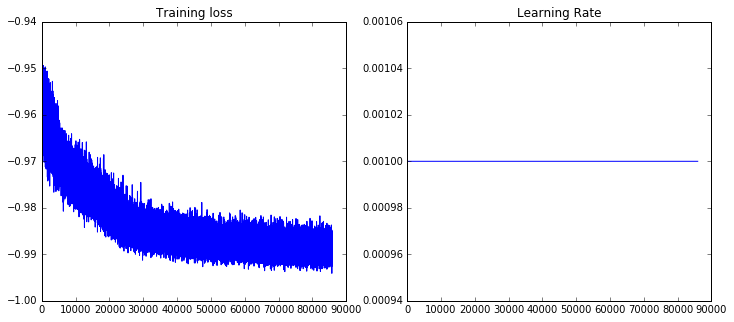

In [196]:
show_train_learnrate(u'rms_momopt', conn = conn_mit)

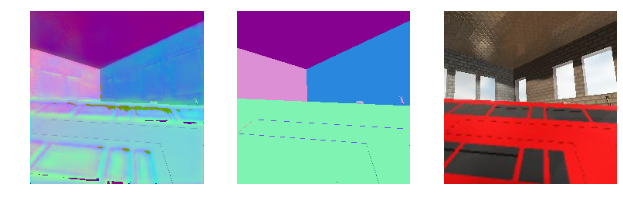

In [197]:
show_result_from_mongodb(u'rms_momopt', 7, 3, 3, conn = conn_mit, cache_flag=True, inv_norm=True)

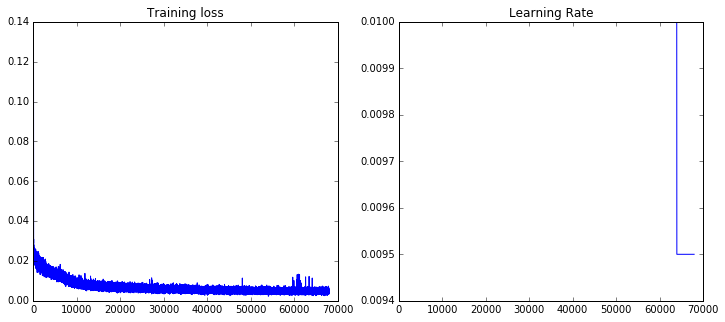

In [133]:
show_train_learnrate(u'trainval1_vgg_hdf5_l2', conn = conn_mit)

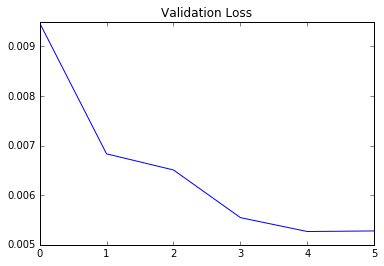

In [134]:
show_val(u'trainval1_vgg_hdf5_l2', conn = conn_mit)

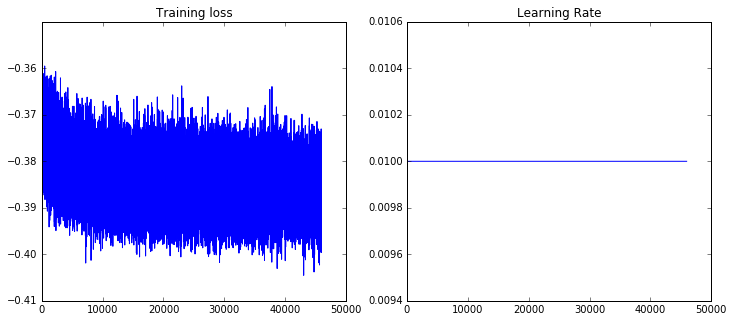

In [29]:
show_train_learnrate(u'trainval1_vgg_hdf5_dot', conn = conn_mit)

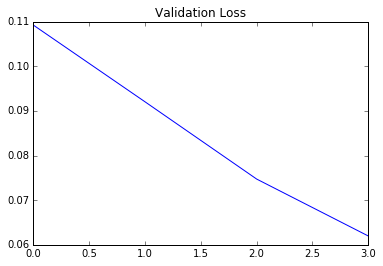

In [30]:
show_val(u'trainval1_vgg_hdf5_dot', conn = conn_mit)

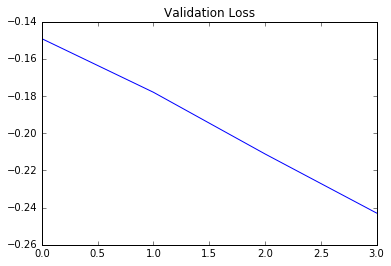

In [36]:
show_val(u'trainval1_vgg_hdf5_dot', conn = conn_mit, key = 'loss_2')

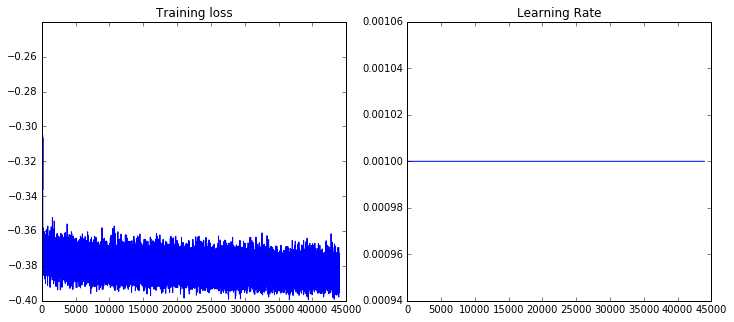

In [31]:
show_train_learnrate(u'trainval1_vgg_hdf5_dot_slow', conn = conn_mit)

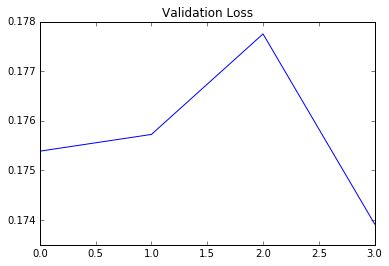

In [32]:
show_val(u'trainval1_vgg_hdf5_dot_slow', conn = conn_mit)

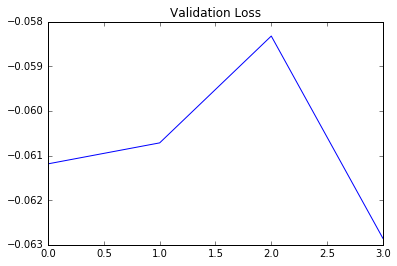

In [34]:
show_val(u'trainval1_vgg_hdf5_dot_slow', conn = conn_mit, key = 'loss_2')

# Visiualization of Hvm

In [14]:
import numpy as np

In [15]:
import dldata.stimulus_sets.hvm as nd; reload(nd)

Can't import separate mcc package
Can't import asgd.


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python2.7/dist-pac

<module 'dldata.stimulus_sets.hvm' from '/home/chengxuz/python_lib/lib/python2.7/site-packages/dldata-dev-py2.7.egg/dldata/stimulus_sets/hvm.pyc'>

In [16]:
dataset = nd.HvMWithDiscfade()

In [17]:

imgs = dataset.get_images(preproc={'resize_to': (256,256), 'dtype': 'float32', 'mode':'L', 'normalize': False})

/usr/local/lib/python2.7/dist-packages/tabular-0.1-py2.7.egg/tabular/utils.py:81: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/tabular-0.1-py2.7.egg/tabular/spreadsheet.py:1458: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


common attributes, forcing a renaming ...
Using default renamer ...


/usr/local/lib/python2.7/dist-packages/tabular-0.1-py2.7.egg/tabular/spreadsheet.py:1484: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


('Replacing columns', ['rxz', 'rxy', 'ryz'])


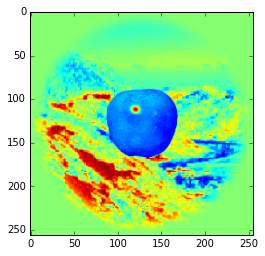

In [18]:
plt.imshow(imgs[0])

In [45]:
imgs_0 = imgs[40]
imgs_0 = np.asarray(imgs_0)

In [46]:

imgs_0_rgb = np.zeros([256, 256, 3])
imgs_0_rgb[:, :, 0] = imgs_0
imgs_0_rgb[:, :, 1] = imgs_0
imgs_0_rgb[:, :, 2] = imgs_0

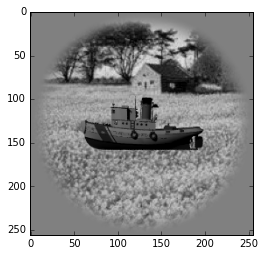

In [47]:
plt.imshow(imgs_0_rgb)

In [48]:
imgs_0_uint8 = imgs_0*255
imgs_0_uint8 = imgs_0_uint8.astype(np.uint8)

In [49]:
imgs_0*255
np.max(imgs_0*255)

231.0

In [50]:
imgs_0_uint8

array([[128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ..., 
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]], dtype=uint8)

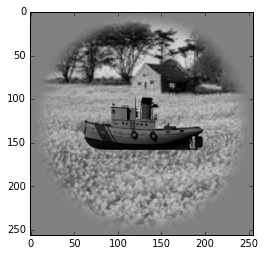

In [52]:

imgs_0_rgb_u = np.zeros([256, 256, 3])
imgs_0_rgb_u[:, :, 0] = imgs_0_uint8
imgs_0_rgb_u[:, :, 1] = imgs_0_uint8
imgs_0_rgb_u[:, :, 2] = imgs_0_uint8
plt.imshow(255 - imgs_0_rgb_u)

In [55]:
want_out_w = 240
want_out_h = 320

from scipy import misc

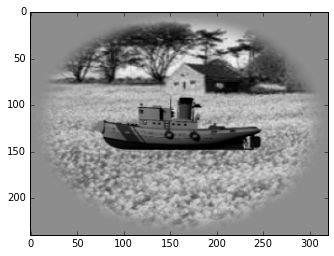

In [57]:
now_img = misc.imresize(imgs_0_rgb_u, [want_out_w, want_out_h])
plt.imshow(now_img)

In [58]:
from PIL import Image
img_path_now = "/home/chengxuz/barrel/barrel_github/barrel/normals_relat/dnl-depthnormals/WechatIMG1.jpeg"
rgb = Image.open(img_path_now)

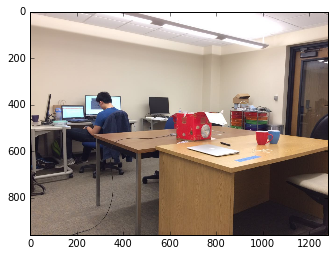

In [59]:
plt.imshow(rgb)

In [60]:
rgb = rgb.resize((320, 240), Image.BICUBIC)

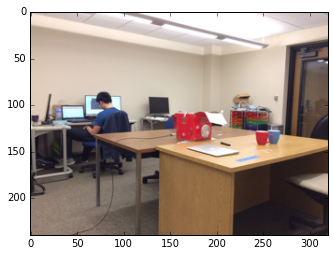

In [61]:
plt.imshow(rgb)

# Other dataset

## Scenenet

In [198]:
photo_now = '/home/chengxuz/barrel/barrel_github/dataset/scenenet/train/0/0/photo/0.jpg'
depth_now = '/home/chengxuz/barrel/barrel_github/dataset/scenenet/train/0/0/depth/0.png'

In [203]:
photo_arr = misc.imread(photo_now)

In [204]:
photo_arr.shape

(240, 320, 3)

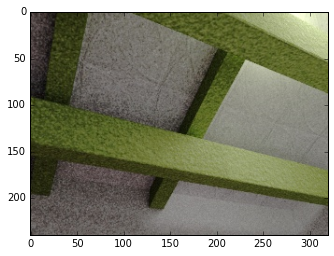

In [205]:
plt.imshow(photo_arr)

In [206]:
depth_arr = misc.imread(depth_now)

In [207]:
depth_arr[0,0]

3259

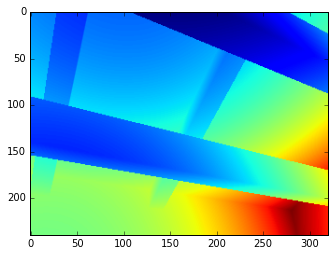

In [208]:
plt.imshow(depth_arr)

In [209]:
depth_arr.shape

(240, 320)

In [6]:
def get_normal_from_depth(depth_arr):
    im_h = depth_arr.shape[0]
    im_w = depth_arr.shape[1]
    
    normal_arr = np.zeros([im_h, im_w, 3])
    
    for indx_x in xrange(1, im_h-1):
        for indx_y in xrange(1, im_w-1):
            dzdx = (depth_arr[indx_x+1, indx_y] - depth_arr[indx_x-1, indx_y])/2.0
            dzdy = (depth_arr[indx_x, indx_y+1] - depth_arr[indx_x, indx_y-1])/2.0
            
            tmp_normal = np.zeros(3)
            #tmp_normal[0] = -dzdx
            #tmp_normal[1] = -dzdy
            tmp_normal[0] = -dzdy
            tmp_normal[1] = -dzdx
            tmp_normal[2] = 1.0
            
            tmp_normal = tmp_normal/np.linalg.norm(tmp_normal)
            tmp_normal = tmp_normal*0.5 + 0.5
            normal_arr[indx_x, indx_y] = tmp_normal
    
    return normal_arr

In [211]:
normal_arr = get_normal_from_depth(depth_arr)

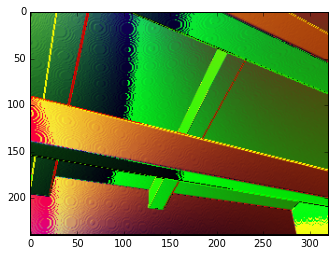

In [212]:
plt.imshow(normal_arr)

In [17]:
def get_normal_from_indx(file_indx, photo_str = '/home/chengxuz/barrel/barrel_github/dataset/scenenet/train/0/0/photo/%i.jpg'
                         , depth_str = '/home/chengxuz/barrel/barrel_github/dataset/scenenet/train/0/0/depth/%i.png'
                         , with_bilat = False, bilat_kwargs = {'d': 5, 'sigmaColor': 12.0, 'sigmaSpace': 16.0}
                         , with_PCA = False, PCA_kwargs = {}):
    photo_now = photo_str % file_indx
    depth_now = depth_str % file_indx
    
    photo_arr = misc.imread(photo_now)
    depth_arr = misc.imread(depth_now)
    
    if with_bilat:
        depth_arr = depth_arr.astype(np.float32)
        
        start = time.time()
        
        depth_arr = cv2.bilateralFilter(depth_arr, **bilat_kwargs)
        print(depth_arr[100][100])
    
    normal_arr = get_normal_from_depth(depth_arr)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(photo_arr)
    ax1.axis('off')
    ax2.imshow(depth_arr)
    ax2.axis('off')
    ax3.imshow(normal_arr)
    plt.gcf().set_size_inches(14.5, 4.5)
    ax3.axis('off')    

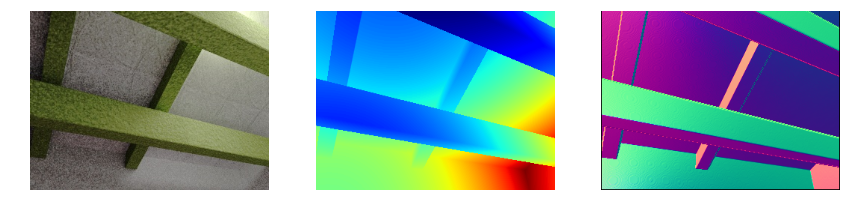

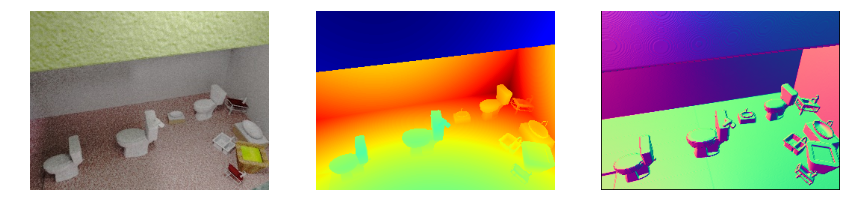

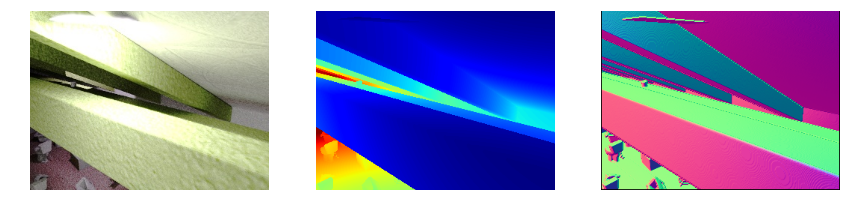

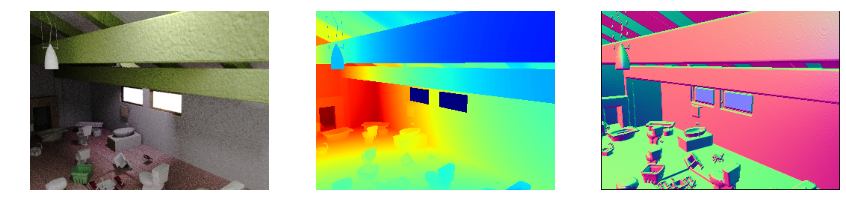

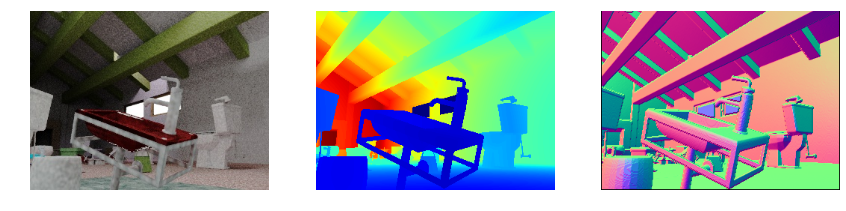

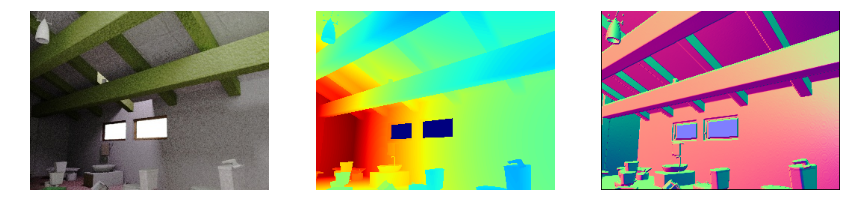

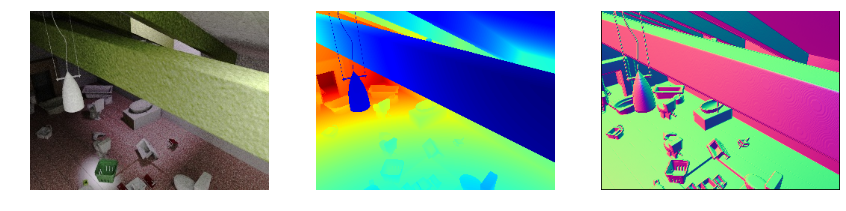

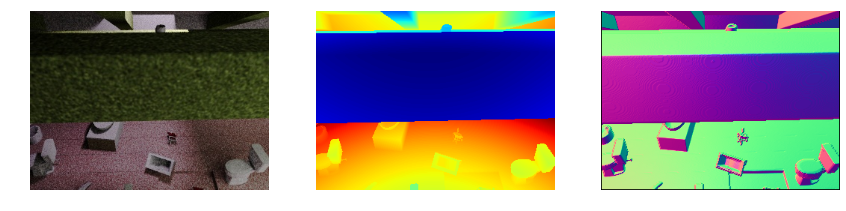

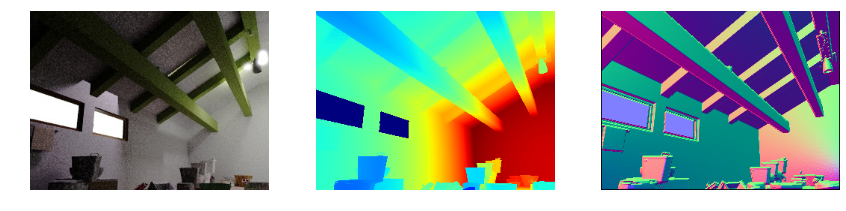

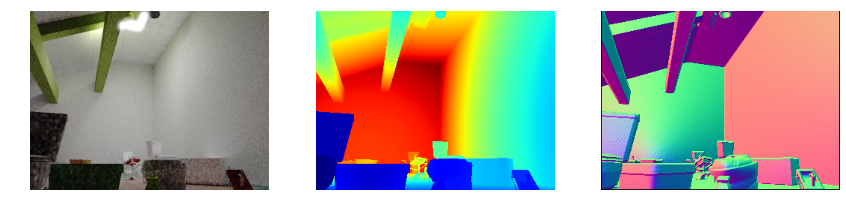

In [239]:
for img_indx in xrange(0, 7000, 700):
    get_normal_from_indx(img_indx)

In [327]:
import h5py

file_name = "/home/chengxuz/barrel/barrel_github/dataset/scenenet/hdf5s/train_0.hdf5"
fin = h5py.File(file_name, 'r')

In [328]:
images = fin['images']
normals = fin['normals']

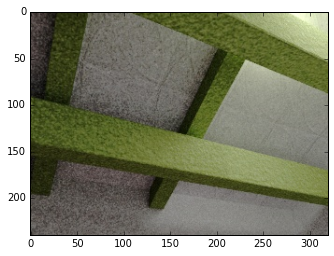

In [329]:
plt.imshow(images[0])

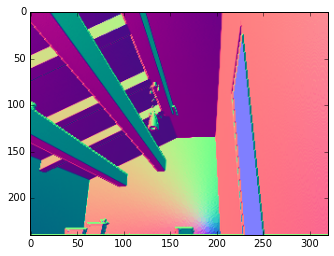

In [330]:
plt.imshow(normals[299])

[ 0.66888199  0.03088336  0.53752933]


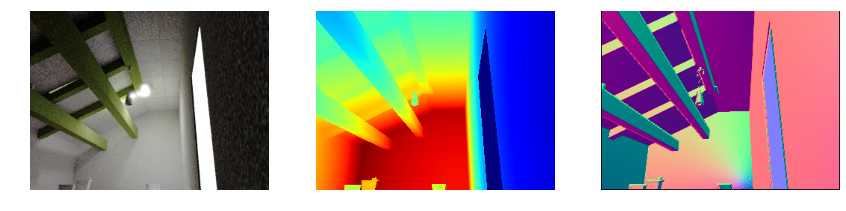

In [332]:
get_normal_from_indx(7475)

In [322]:
normals[700//25][10, 10]

array([189,  34, 189], dtype=uint8)

In [309]:
0.13619656*255

34.7301228

## Scannet

In [2]:
import h5py

In [3]:
from scipy import misc

In [9]:
test_out_path = '/home/chengxuz/barrel/barrel_github/dataset/scannet/ScanNet/SensReader/test_out/'

In [6]:
import os
depth_arr = misc.imread(os.path.join(test_out_path, 'frame-000000.depth.pgm'))

In [7]:
depth_arr.shape

(480, 640)

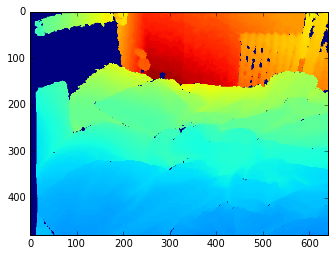

In [8]:
plt.imshow(depth_arr)

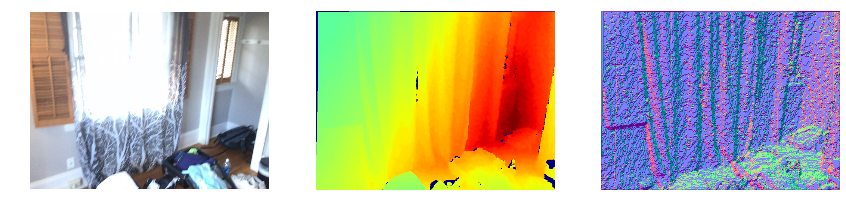

In [16]:
get_normal_from_indx(1090, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm')

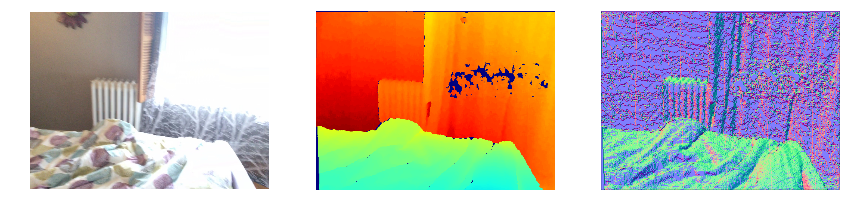

In [17]:
get_normal_from_indx(290, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm')

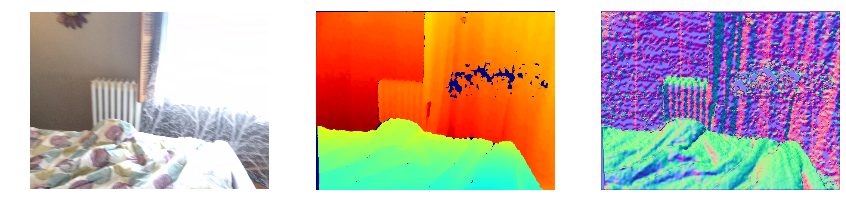

In [20]:
get_normal_from_indx(290, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': 9, 'sigmaColor': 12.0, 'sigmaSpace': 16.0})

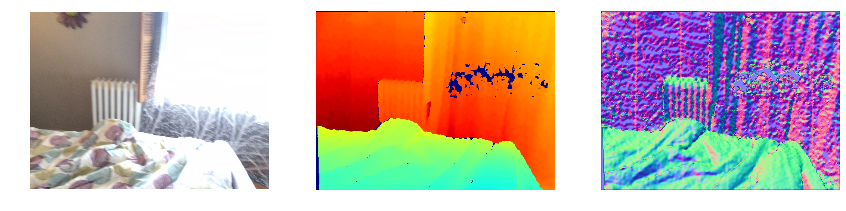

In [21]:
get_normal_from_indx(290, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': 9, 'sigmaColor': 16.0, 'sigmaSpace': 16.0})

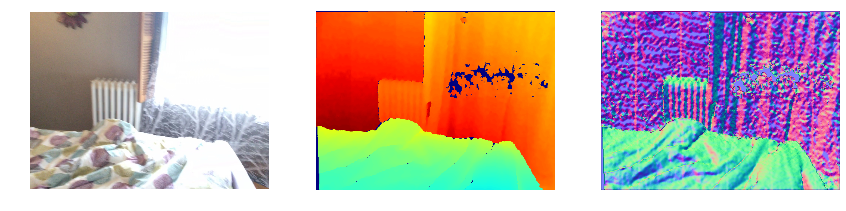

In [23]:
get_normal_from_indx(290, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': 9, 'sigmaColor': 20.0, 'sigmaSpace': 20.0})

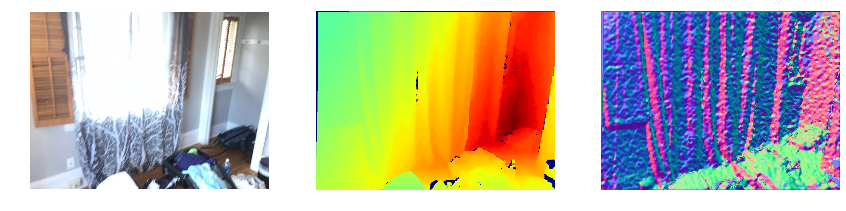

In [25]:
get_normal_from_indx(1090, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': 9, 'sigmaColor': 30.0, 'sigmaSpace': 30.0})

1695.69


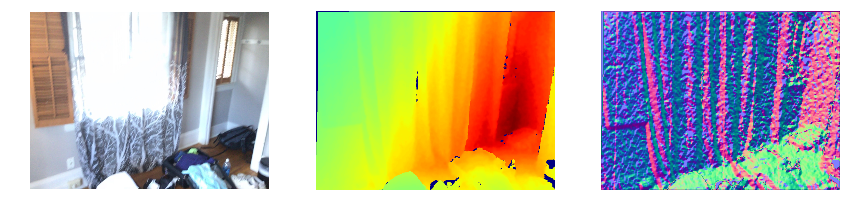

In [23]:
get_normal_from_indx(1090, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': -5, 'sigmaColor': 100, 'sigmaSpace': 2})

1695.69


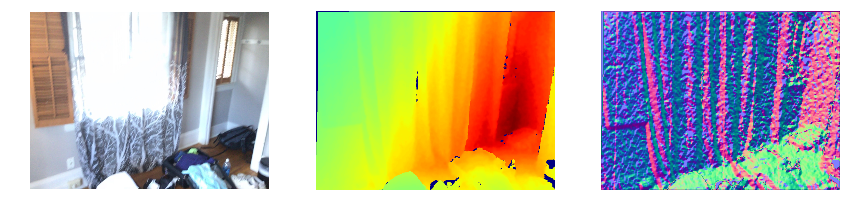

In [24]:
get_normal_from_indx(1090, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': -1, 'sigmaColor': 100, 'sigmaSpace': 2})

0.0


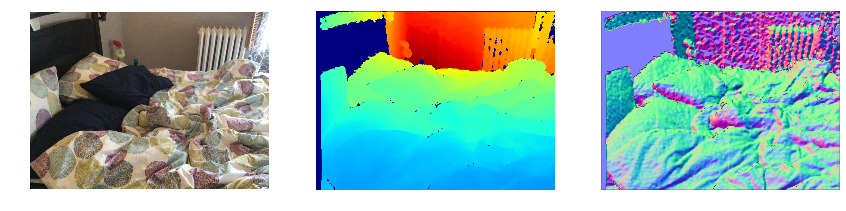

In [25]:
get_normal_from_indx(0, photo_str=test_out_path+'frame-%06i.color.jpg', depth_str=test_out_path+'frame-%06i.depth.pgm'
                     , with_bilat=True, bilat_kwargs = {'d': -1, 'sigmaColor': 100, 'sigmaSpace': 2})

# NYUv2 dataset

In [1]:
dataset_path = '/home/chengxuz/barrel/barrel_github/dataset/nyuv2/nyuv2/study_0005'

In [11]:
import cv2

In [30]:
dep_img_path = os.path.join(dataset_path, 'd-1315360829.813327-3781852712.pgm')

In [31]:
rgb_img_path = os.path.join(dataset_path, 'r-1315360829.841904-3783312126.ppm')

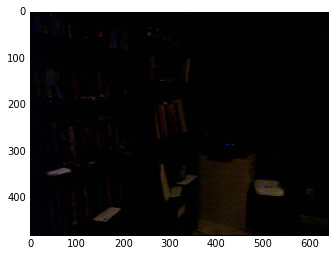

In [32]:
rgb_arr = misc.imread(rgb_img_path)
plt.imshow(rgb_arr)

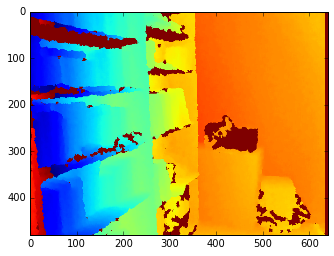

In [33]:
dep_arr = misc.imread(dep_img_path)
plt.imshow(dep_arr)

In [34]:
dep_arr[0,0]

3587

In [36]:
dep_arr.dtype

dtype('int32')

In [40]:
dep_arr = dep_arr.astype(np.uint16)

In [43]:
dep_arr = dep_arr.byteswap()

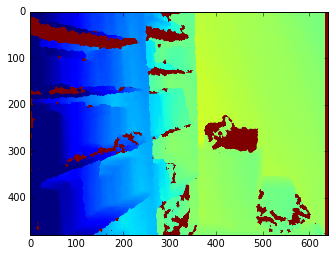

In [48]:
plt.imshow(dep_arr, clim=(800, 1100))

In [49]:
dep_arr

array([[ 782,  782,  782, ..., 2047, 2047, 2047],
       [ 782,  782,  782, ..., 2047, 2047, 2047],
       [ 783,  783,  784, ..., 2047, 2047, 2047],
       ..., 
       [ 743,  743,  743, ..., 2047, 2047, 2047],
       [ 743,  743,  743, ..., 2047, 2047, 2047],
       [ 743,  743,  743, ..., 2047, 2047, 2047]], dtype=uint16)

In [50]:
dep_arr[30,30]

2047

In [51]:
dep_arr[0, 0:20]

array([782, 782, 782, 784, 785, 784, 785, 786, 787, 787, 788, 789, 791,
       792, 792, 793, 793, 794, 794, 795], dtype=uint16)